In [1]:
%pprint

Pretty printing has been turned OFF


## 2016 Election Project 
### Part 2 of Processing Pipeline

This notebook is intended to document NER annotation of my data throughout this project. The data I am starting out with are transcripts of the presidential debates from the 2016 US Election- the 10 Democratic primary debates, the 12 Republican primary debates, and the debates for the general election between Hillary Clinton and Donald Trump. The transcripts were taken from UCSB's American Presidency Project. The citations for these transcripts can be found in the README.

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import re

**I'm going to create a mapping function that will take the sentence in each row of each data frame and perform nltk's chunking operation on it to get a tree with annoted NEs**

In [3]:
#Import the saved list of data frames I created in secondary_data_processing
import pickle
f = open('/Users/Paige/Documents/Data_Science/dataframes.p', 'rb')
dataframes = pickle.load(f)
f.close()

In [4]:
def get_tree(sent):
    sents = nltk.sent_tokenize(sent)
    words = [nltk.word_tokenize(sent) for sent in sents]
    pos = [nltk.pos_tag(sent) for sent in words]
    chunk = nltk.ne_chunk_sents(pos)
    return list(chunk)

In [5]:
master_df = pd.concat(dataframes)

In [6]:
master_df.head()

,Date,Debate Type,Speaker,Sents
2,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...
3,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...
4,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo..."
5,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...
6,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h..."


In [7]:
master_df.tail()

,Date,Debate Type,Speaker,Sents
1382,9-26-16,general,HOLT,The conversation will continue.
1383,9-26-16,general,HOLT,A reminder.
1384,9-26-16,general,HOLT,The vice presidential debate is scheduled for ...
1385,9-26-16,general,HOLT,My thanks to Hillary Clinton and to Donald Tru...
1386,9-26-16,general,HOLT,"Good night, everyone."


In [8]:
master_df['Tree']=master_df.Sents.map(get_tree)

In [10]:
master_df.head()

,Date,Debate Type,Speaker,Sents,Tree
2,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...,"[[(It, PRP), (is, VBZ), (9:00, CD), (p.m., NN)..."
3,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...,"[[(Welcome, VB), (to, TO), (the, DT), (sixth, ..."
4,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo...","[[(I, PRP), ('m, VBP), [('Neil', 'JJ'), ('Cavu..."
5,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...,"[[(Tonight, NN), (we, PRP), (are, VBP), (worki..."
6,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h...","[[(And, CC), (according, VBG), (to, TO), [('Fa..."


**I've created an NER tree! Notice that nltk's chunker pulled out Neil Cavuto and Maria Bartiromo as people. Now I want to change the S label at the top of the tree to represent who said this utterence using the information in the Speaker column.**

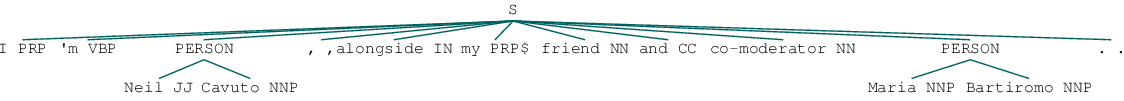

In [15]:
master_df.iloc[2][-1][0]

In [22]:
#Using mapping involving 2 columns. Use the Speaker column to modify the Tree column.
for row in range(0, len(master_df)):
    master_df.iloc[row][-1][0].set_label(master_df.iloc[row][2])

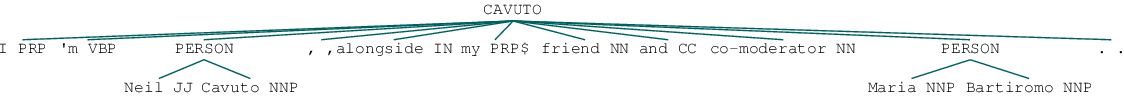

In [23]:
master_df.iloc[2]['Tree'][0]

In [24]:
master_df.iloc[2]['Speaker']

'CAVUTO'

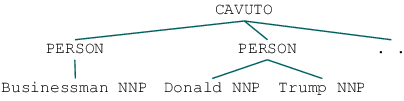

In [34]:
#Uh oh. The good news is the chunker got Trump's title- Businessman. The bad news is it's separated from the rest of his name. I'll have to fix that.
master_df.iloc[8]['Tree'][0]

In [33]:
master_df.iloc[8]['Speaker']

'CAVUTO'

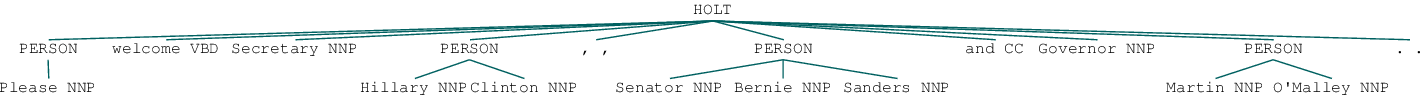

In [61]:
#Again, it got Hillary Clinton and Martin O'Malley, but missed Secretary and Governor, but it DID get Senator Bernie Sanders
master_df.iloc[1603]['Tree'][0]

In [62]:
master_df.iloc[1603]['Speaker']

'HOLT'

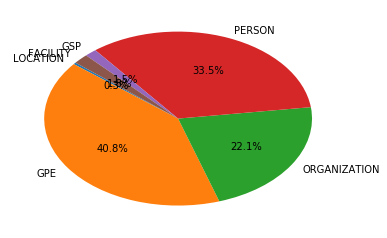

In [64]:
#This section is with help from a datacamp tutorial
#https://campus.datacamp.com/courses/natural-language-processing-fundamentals-in-python/named-entity-recognition?ex=3

ner_categories = defaultdict(int)

# Create the nested for loop
for tree_list in master_df['Tree']:
    for tree in tree_list:
        for chunk in tree:
            if hasattr(chunk, 'label'):
                ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

In [67]:
people = []
for tree_list in master_df['Tree']:
    for tree in tree_list:
        for chunk in tree:
            if hasattr(chunk, 'label'):
                if chunk.label() == 'PERSON':
                    people.append(chunk)

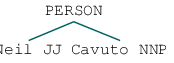

In [75]:
people[1]

In [74]:
people[1].leaves()[0][0]
words = [leaf[0] for leaf in people[1].leaves()]
words

['Neil', 'Cavuto']

In [76]:
people_names = []
name = ''
for tree in people:
    for leaf in tree.leaves():
        name+=' '+str(leaf[0])
    people_names.append(name.strip())
    name = ''


In [78]:
names = set(people_names)
names

{'Sean Hannity', 'Make', 'Raul Castro', 'Center', 'Howard Dean', 'Jake Tapper', 'Florida Senator', 'Hill', 'Hey Ted', 'Bob Jones', 'Bibi Netanyahu', 'Madame', 'Mr. Mcgee', 'Avenue Q', 'Mr. Cruz', 'Bret', 'Bob Graham', 'John Deere', 'Mark Levin', 'Milwaukee Public Television', 'Annie Oakley', 'Tom Harkin', 'Had', 'Dulce', 'Morgan Stanley', 'John Quincy Adams', 'Yasser Arafat', 'Title', 'Nabela Noor', 'Rubio', 'Bobby Jindal', 'Mine', 'Beyond', 'Trust', 'Google', 'Sabina', 'Lucia', 'Shaheen', 'Francisco', 'George Shultz', 'Juan Carlos Lopez', 'Super PACs', 'Gorbah Hamed', 'Andrea', 'Budget Committee', 'Enrique Cevedo', 'Monopoly', 'Make America Great Again', 'Social Security', 'Arnold', 'Lehman', 'Carla', 'Charlie', 'Ohio Governor', 'Pew Report', 'Kathy', 'John Harwood', 'Vietnam', 'Deborah Wasserman Schultz', 'Ted Cruz', 'Barak Obama America', 'Everybody', 'Brian Carlson', 'Jim', 'George', 'Rick Snyder', 'Fox Business Network', 'Moines Register', 'Wired', 'Mossadegh', 'Shultz', 'Catherin

In [92]:
len(names)

1135

In [82]:
'Senator' in names

True

In [83]:
'Governor' in names

False

In [84]:
'Mr.' in names

True

In [85]:
'Mrs.' in names

False

In [86]:
'Miss' in names

False

In [87]:
'Doctor' in names

True

In [88]:
'President' in names

False

**I'm going to go through all of these tags by hand, and link them to who they are referring to. I will create a dictionary in a small additional script that creates a dictionary of NEs. The expression that was used will be the key, and the person it refers to will be the value. I think copying and pasting this set and deleting things that obviously are not people by hand first will speed things up.**

In [93]:
f = open('/Users/Paige/Documents/Data_Science/names.txt', 'w')
for name in names:
    f.write(str(name)+'\n')
f.close()